In [1]:
import flwr as fl
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split
from torchvision.datasets import CIFAR10
from collections import OrderedDict
from typing import Dict, List, Optional, Tuple
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader, random_split
import uuid
from datetime import datetime
import os
from PIL import Image
import cv2
from skimage.metrics import structural_similarity as ssim
import torchvision.transforms.functional as TF

DEVICE = torch.device("cuda")  #"cuda" or "cpu"
print(
    f"Training on {DEVICE} using PyTorch {torch.__version__} and Flower {fl.__version__}"
)

Training on cuda using PyTorch 2.2.2+cu121 and Flower 1.8.0


In [2]:
class ChestXrayDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.images = [os.path.join(root_dir, fname) for fname in os.listdir(root_dir) if fname.endswith('.png') or fname.endswith('.jpeg')]

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_name = self.images[idx]
        image = Image.open(img_name).convert('L')
        if self.transform:
            image = self.transform(image)
        return image

In [3]:
def load_datasets(num_clients: int, dataset_path: str, train_transform, test_transform):
    # Initialize dataset
    dataset = ChestXrayDataset(root_dir=dataset_path, transform=train_transform)
    
    # Calculate lengths for training and testing
    total_len = len(dataset)
    train_len = int(total_len * 0.8)  # 80% for training
    test_len = total_len - train_len  # remaining for testing
    
    # Split dataset into training and testing
    trainset, testset = random_split(dataset, [train_len, test_len], generator=torch.Generator().manual_seed(42))

    # Split training set into `num_clients` partitions
    partition_size = train_len // num_clients
    lengths = [partition_size] * num_clients
    if train_len % num_clients != 0:
        lengths[-1] += train_len % num_clients
    datasets = random_split(trainset, lengths, generator=torch.Generator().manual_seed(42))

    # Create DataLoaders for each client's dataset
    trainloaders = [DataLoader(ds, batch_size=64, shuffle=True) for ds in datasets]

    # Prepare the test set DataLoader with the appropriate transformation
    testset = ChestXrayDataset(root_dir=dataset_path, transform=test_transform)
    testloader = DataLoader(testset, batch_size=64, shuffle=False)

    return trainloaders, testloader

# Sample usage with transforms and dataset path
train_transform = transforms.Compose([
    transforms.Resize((256, 256)),  # Resize images to 256x256
    transforms.ToTensor(),  # Convert image to tensor
    transforms.Normalize((0.5,), (0.5,))  # Normalize for 1 channel
])

test_transform = transforms.Compose([
    transforms.Resize((256, 256)),  # Resize images to 256x256
    transforms.ToTensor(),  # Convert image to tensor
    transforms.Normalize((0.5,), (0.5,))  # Normalize for 1 channel
])

dataset_path = 'NewNormal'
NUM_CLIENTS = 10
trainloaders, testloader = load_datasets(NUM_CLIENTS, dataset_path, train_transform, test_transform)

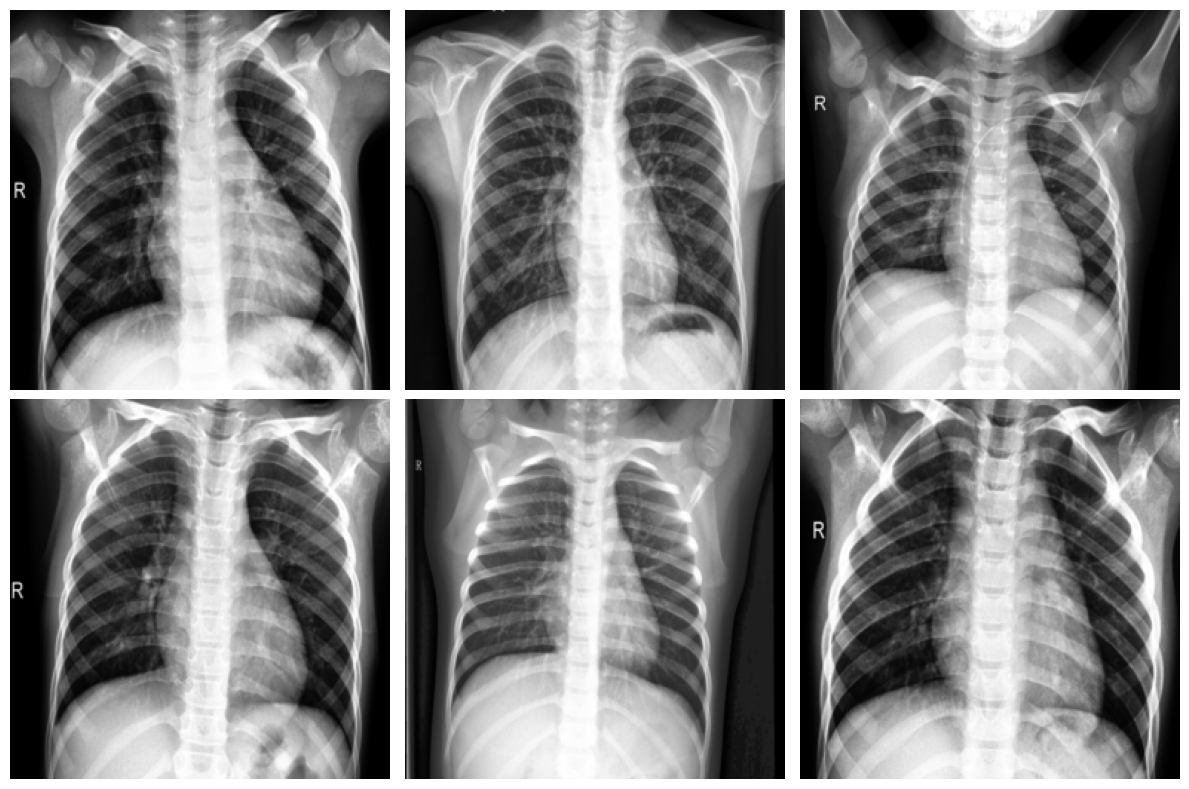

In [4]:
def show_dataset_images(dataloader, num_images=6, image_size=(256, 256)):
    # Retrieve a batch of images (and labels if they exist)
    data = next(iter(dataloader))
    if isinstance(data, tuple) and len(data) == 2:
        images, labels = data
    else:
        images = data
        labels = [None] * len(images)  # Create a placeholder for labels if they are not available
    
    plt.figure(figsize=(12, 8))  # Increase figure size for better visibility

    for i in range(min(num_images, len(images))):  # Ensure not to exceed the number of images in the batch
        ax = plt.subplot(2, 3, i + 1)
        img = images[i].numpy().transpose((1, 2, 0))  # Convert tensor image to numpy and fix the channel order
        mean = 0.5  # Mean used in Normalize
        std = 0.5   # Std used in Normalize
        img = std * img + mean  # Unnormalize the image
        img = np.clip(img, 0, 1)  # Clip values to ensure they're between 0 and 1

        img = cv2.resize(img, image_size)  # Resize the image to the desired size

        plt.imshow(img, cmap='gray')  # Use gray color map for X-ray images
        if labels[i] is not None:
            ax.set_title(f'Label: {labels[i]}')
        ax.axis('off')

    plt.tight_layout()  # Adjust subplots to fit into figure area.
    plt.show()

# Example usage (make sure you have a DataLoader available as trainloaders[0] from your federated setup)
show_dataset_images(trainloaders[0], num_images=6, image_size=(256, 256))

In [5]:
class SparseAutoencoder(nn.Module):
    def __init__(self):
        super(SparseAutoencoder, self).__init__()
        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, 3, stride=2, padding=1),  # Input is 1 channel
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Conv2d(16, 32, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Conv2d(32, 64, 7),
            nn.ReLU(),
        )
        # Decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, 7),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, 3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 1, 3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [6]:
def train(net, trainloader, epochs: int, optimizer):
    """Train the autoencoder on the training set."""
    criterion = torch.nn.MSELoss()
    net.train()
    for epoch in range(epochs):
        total_loss = 0.0
        for batch in trainloader:
            images = batch.to(DEVICE)  # Assuming the DataLoader returns a tuple (images, labels)
            optimizer.zero_grad()
            outputs = net(images)
            loss = criterion(outputs, images)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        average_loss = total_loss / len(trainloader)
        print(f"Epoch {epoch+1}: train loss {average_loss:.4f}")
        
def test(net, testloader):
    """Evaluate the autoencoder on the test set."""
    criterion = torch.nn.MSELoss()
    total_loss = 0.0
    net.to(DEVICE)  # Move model to GPU if available
    net.eval()
    with torch.no_grad():
        for batch in testloader:
            images = batch[0].to(DEVICE)  # Move data to GPU if available
            outputs = net(images)
            loss = criterion(outputs, images)
            total_loss += loss.item()
    average_loss = total_loss / len(testloader)
    print(f"Test loss: {average_loss:.4f}")
    return average_loss

In [7]:
def get_parameters(net) -> List[np.ndarray]:
    # Return the parameters of the network as a list of NumPy arrays.
    return [val.cpu().numpy() for _, val in net.state_dict().items()]

def set_parameters(net, parameters: List[np.ndarray]):
    # Set the parameters of the network from a list of NumPy arrays.
    params_dict = zip(net.state_dict().keys(), parameters)  # Pair parameter names with given arrays.
    # Create an ordered dictionary of parameters, converting arrays to tensors.
    state_dict = OrderedDict({k: torch.Tensor(v) for k, v in params_dict})  
    net.load_state_dict(state_dict, strict=True)  # Load the parameters into the network.

In [8]:
from flwr.common import (
    Code,
    EvaluateIns,
    EvaluateRes,
    FitIns,
    FitRes,
    GetParametersIns,
    GetParametersRes,
    Parameters,
    Scalar,
    Status,
    ndarrays_to_parameters,
    parameters_to_ndarrays,
)

In [9]:
class FlowerClient(fl.client.Client):
    def __init__(self, cid, net, trainloader, optimizer, scheduler, epochs_per_round):
        self.cid = cid
        self.net = net
        self.trainloader = trainloader
        self.optimizer = optimizer
        self.scheduler = scheduler
        self.epochs_per_round = epochs_per_round  # Number of epochs per client per round

    def get_parameters(self, ins: fl.common.GetParametersIns) -> fl.common.GetParametersRes:
        print(f"[Client {self.cid}] get_parameters")
        ndarrays = get_parameters(self.net)
        parameters = ndarrays_to_parameters(ndarrays)
        status = fl.common.Status(code=fl.common.Code.OK, message="Parameters retrieved")
        return fl.common.GetParametersRes(status=status, parameters=parameters)

    def fit(self, ins: fl.common.FitIns) -> fl.common.FitRes:
        print(f"[Client {self.cid}] fit, config: {ins.config}")
        ndarrays = parameters_to_ndarrays(ins.parameters)
        set_parameters(self.net, ndarrays)
        train(self.net, self.trainloader, epochs=self.epochs_per_round, optimizer=self.optimizer)
        updated_ndarrays = get_parameters(self.net)
        updated_parameters = ndarrays_to_parameters(updated_ndarrays)
        status = fl.common.Status(code=fl.common.Code.OK, message="Model trained")
        return fl.common.FitRes(status=status, parameters=updated_parameters, num_examples=len(self.trainloader), metrics={})

    def evaluate(self, ins: fl.common.EvaluateIns) -> fl.common.EvaluateRes:
        print(f"[Client {self.cid}] evaluate, config: {ins.config}")
        ndarrays = parameters_to_ndarrays(ins.parameters)
        set_parameters(self.net, ndarrays)

        # Perform reconstruction and calculate SSIM using trainloader
        total_ssim = 0.0
        total_items = 0
        self.net.eval()
        with torch.no_grad():
            for images in self.trainloader:
                images = images.to(DEVICE)  # Ensure that images are moved to the correct device
                outputs = self.net(images)
                
                # Convert images and outputs to numpy arrays for SSIM calculation
                images_np = images.cpu().numpy().transpose(0, 2, 3, 1)
                outputs_np = outputs.cpu().numpy().transpose(0, 2, 3, 1)
                
                for img, out in zip(images_np, outputs_np):
                    img_gray = TF.to_pil_image(img).convert("L")
                    out_gray = TF.to_pil_image(out).convert("L")
                    img_gray = np.array(img_gray)
                    out_gray = np.array(out_gray)
                    ssim_value = ssim(img_gray, out_gray, data_range=img_gray.max() - img_gray.min())
                    total_ssim += ssim_value
                total_items += images.size(0)

        average_ssim = total_ssim / total_items if total_items > 0 else 0

        return fl.common.EvaluateRes(
            status=fl.common.Status(code=fl.common.Code.OK, message="Evaluation completed"),
            loss=1 - average_ssim,  # Loss is 1 - SSIM to keep lower loss better
            num_examples=total_items,
            metrics={"ssim": average_ssim}  # Report SSIM
        )

In [10]:
def client_fn(cid) -> FlowerClient:
    net = SparseAutoencoder().to(DEVICE)  # Assuming SparseAutoencoder is the model class
    trainloader = trainloaders[int(cid)]
    optimizer = torch.optim.Adam(net.parameters(), lr=0.001)  # Set your desired learning rate here
    scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3, verbose=True)
    return FlowerClient(cid, net, trainloader, optimizer, scheduler, epochs_per_round=3)  # Adjust number of epochs per client per round

In [11]:
import flwr as fl
from typing import Callable, Dict, List, Optional, Tuple, Union
from flwr.common import (
    EvaluateIns,
    EvaluateRes,
    FitIns,
    FitRes,
    Parameters,
    Scalar,
    ndarrays_to_parameters,
    parameters_to_ndarrays,
)
from flwr.server.client_manager import ClientManager
from flwr.server.client_proxy import ClientProxy
from flwr.server.strategy.aggregate import aggregate, weighted_loss_avg

import random
from flwr.server.strategy import Strategy
from flwr.common import Parameters, Scalar
from flwr.server.client_manager import ClientManager
from flwr.server.client_proxy import ClientProxy
from flwr.server.client_proxy import FitIns, FitRes
from typing import List, Optional, Tuple, Union
import numpy as np
from collections import OrderedDict
from typing import List, Tuple, Dict, Optional, Union
import flwr as fl
from flwr.server.strategy import Strategy
from flwr.server.client_manager import ClientManager
from flwr.common import Parameters, Scalar, FitIns, FitRes, EvaluateIns, EvaluateRes, parameters_to_ndarrays, ndarrays_to_parameters
from datetime import datetime
import torch
from torch.optim.lr_scheduler import ReduceLROnPlateau

from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
import torch
import csv
from sklearn.cluster import KMeans
import numpy as np
import torch
from torch.optim.lr_scheduler import StepLR
import h5py

In [26]:
import csv
from sklearn.cluster import KMeans
import numpy as np
import torch
from torch.optim.lr_scheduler import StepLR
import h5py
import flwr as fl

class FedCustom(fl.server.strategy.Strategy):
    def __init__(
        self,
        fraction_fit: float = 1.0,
        fraction_evaluate: float = 1.0,
        min_fit_clients: int = 2,
        min_evaluate_clients: int = 2,
        min_available_clients: int = 2,
        initial_lr: float = 0.0005,
        step_size: int = 30,
        gamma: float = 0.9,
        num_clusters: int = 3  # Number of clusters
    ) -> None:
        self.fraction_fit = fraction_fit
        self.fraction_evaluate = fraction_evaluate
        self.min_fit_clients = min_fit_clients
        self.min_evaluate_clients = min_evaluate_clients
        self.min_available_clients = min_available_clients
        self.redistributed_parameters = {}
        self.initial_lr = initial_lr
        self.step_size = step_size
        self.gamma = gamma
        self.scheduler = None
        self.num_clusters = num_clusters  # Fixed number of clusters
        self.cluster_labels = None
        self.cluster_models = {cluster: None for cluster in range(self.num_clusters)}

    def initialize_parameters(self, client_manager: fl.server.ClientManager) -> Optional[fl.common.Parameters]:
        net = SparseAutoencoder()
        ndarrays = get_parameters(net)
        return fl.common.ndarrays_to_parameters(ndarrays)

    def configure_fit(self, server_round: int, parameters: fl.common.Parameters, client_manager: fl.server.ClientManager) -> List[Tuple[fl.server.client_proxy.ClientProxy, fl.common.FitIns]]:
        num_clients = len(client_manager)
        if num_clients < self.min_fit_clients:
            return []

        sample_size = int(num_clients * self.fraction_fit)
        sample_size = max(sample_size, self.min_fit_clients)
        clients = client_manager.sample(num_clients=sample_size, min_num_clients=self.min_fit_clients)

        # Assign cluster-specific parameters to each client
        fit_configurations = []
        for client in clients:
            client_id = client.cid
            if server_round > 1 and self.cluster_labels is not None:
                cluster = self.cluster_labels[int(client_id) % len(self.cluster_labels)]
                parameters = self.cluster_models[cluster]
            fit_configurations.append((client, fl.common.FitIns(parameters, {"server_round": server_round})))

        return fit_configurations

    def aggregate_parameters(self, parameters_list: List[List[np.ndarray]], server_round: int) -> Tuple[List[np.ndarray], np.ndarray]:
        """Aggregate model parameters by clustering based on MSE every 5 rounds."""
        num_models = len(parameters_list)
    
        #if server_round >= 1:
        #if server_round == 1 or server_round % 10 == 0:
        if server_round == 1 or server_round % 50 == 0:
            # Flatten the parameter arrays to create a feature vector for each model
            flattened_parameters = [np.concatenate([param.flatten() for param in params]) for params in parameters_list]
    
            # Compute the pairwise MSE distance matrix
            mse_matrix = np.zeros((num_models, num_models))
            for i in range(num_models):
                for j in range(i + 1, num_models):
                    mse_matrix[i, j] = np.mean((flattened_parameters[i] - flattened_parameters[j]) ** 2)
                    mse_matrix[j, i] = mse_matrix[i, j]
    
            # Perform clustering using KMeans with the MSE distance matrix
            kmeans = KMeans(n_clusters=self.num_clusters, random_state=0, n_init='auto')
            cluster_labels = kmeans.fit_predict(mse_matrix)
        else:
            # Load the cluster labels from the last clustering round if the file exists
            if os.path.exists('cluster_assignments.h5'):
                with h5py.File('cluster_assignments.h5', 'r') as f:
                    previous_rounds = [int(r) for r in f.keys() if int(r) < server_round]
                    if previous_rounds:
                        last_round = max(previous_rounds)
                        cluster_labels = f[str(last_round)]['cluster_labels'][:]
                    else:
                        # Initialize cluster labels to zero if no previous round exists
                        cluster_labels = np.zeros(num_models, dtype=int)
            else:
                # Initialize cluster labels to zero if file does not exist
                cluster_labels = np.zeros(num_models, dtype=int)
    
        # Aggregate parameters within each cluster
        aggregated_parameters = []
        for cluster in range(self.num_clusters):
            cluster_parameters = [parameters_list[i] for i in range(num_models) if cluster_labels[i] == cluster]
            if cluster_parameters:
                cluster_aggregated_parameters = [np.mean(np.array(param_tuple), axis=0) for param_tuple in zip(*cluster_parameters)]
                aggregated_parameters.append(cluster_aggregated_parameters)
    
        # Further aggregate the cluster centers to obtain the final parameters
        if aggregated_parameters:
            final_aggregated_parameters = [np.mean(np.array(param_tuple), axis=0) for param_tuple in zip(*aggregated_parameters)]
        else:
            final_aggregated_parameters = [np.zeros_like(param) for param in parameters_list[0]]
    
        # Update the cluster models for the next round
        self.cluster_models = {cluster: fl.common.ndarrays_to_parameters(params) for cluster, params in enumerate(aggregated_parameters)}
    
        return final_aggregated_parameters, cluster_labels


    def aggregate_fit(
        self, server_round: int, results: List[Tuple[fl.server.client_proxy.ClientProxy, fl.common.FitRes]], failures: List[Union[Tuple[fl.server.client_proxy.ClientProxy, fl.common.FitRes], BaseException]]
    ) -> Tuple[Optional[fl.common.Parameters], Dict[str, fl.common.Scalar]]:
        if not results:
            return None, {}

        parameters_list = [parameters_to_ndarrays(res.parameters) for client, res in results]
        aggregated_parameters, cluster_labels = self.aggregate_parameters(parameters_list, server_round)
        aggregated_parameters_fl = fl.common.ndarrays_to_parameters(aggregated_parameters)

        # Save the latest model for each cluster
        for cluster, params in self.cluster_models.items():
            net = SparseAutoencoder()
            state_dict = aggregated_parameters_to_state_dict(parameters_to_ndarrays(params))
            net.load_state_dict(state_dict)
            torch.save(net.state_dict(), f"latest_model_cluster_{cluster}.pth")

        self.cluster_labels = cluster_labels  # Store cluster_labels for use in aggregate_evaluate

        return aggregated_parameters_fl, {}

    def configure_evaluate(self, server_round: int, parameters: fl.common.Parameters, client_manager: fl.server.ClientManager) -> List[Tuple[fl.server.client_proxy.ClientProxy, fl.common.EvaluateIns]]:
        if self.fraction_evaluate == 0.0:
            return []

        config = {"server_round": server_round, "task": "evaluate"}

        sample_size, min_num_clients = self.num_evaluation_clients(client_manager.num_available())
        clients = client_manager.sample(num_clients=sample_size, min_num_clients=min_num_clients)
        evaluate_ins = fl.common.EvaluateIns(parameters, config=config)

        return [(client, evaluate_ins) for client in clients]

    def aggregate_evaluate(self, server_round: int, results: List[Tuple[fl.server.client_proxy.ClientProxy, fl.common.EvaluateRes]], failures: List[Union[Tuple[fl.server.client_proxy.ClientProxy, fl.common.EvaluateRes], BaseException]]) -> Tuple[Optional[float], Dict[str, fl.common.Scalar]]:
        if not results:
            return None, {}
    
        total_ssim = 0.0
        total_examples = 0
        current_time = datetime.now().strftime('%Y-%m-%d %H:%M:%S')
        ssim_file_path = 'ssim_scores.ncol'
        evaluation_file_path = 'aggregated_evaluation_loss.txt'
    
        ssim_scores = []
    
        for client, res in results:
            if 'ssim' in res.metrics:
                ssim_scores.append((client.cid, res.metrics['ssim']))
    
            total_ssim += res.metrics['ssim'] * res.num_examples
            total_examples += res.num_examples
    
        aggregated_ssim = total_ssim / total_examples if total_examples > 0 else None
    
        ssim_scores.sort(key=lambda x: int(x[0]))
    
        with open(ssim_file_path, 'a') as file:
            file.write(f"Time: {current_time} - Round {server_round}\n")
            for cid, score in ssim_scores:
                file.write(f"{cid} {score}\n")
    
        if self.scheduler is None:
            self.optimizer = torch.optim.Adam([torch.nn.Parameter(torch.tensor([1.0]))], lr=self.initial_lr)
            self.scheduler = StepLR(self.optimizer, step_size=self.step_size, gamma=self.gamma)
    
        cluster_ssim_scores = self._compute_cluster_ssim(results)
    
        if aggregated_ssim is not None:
            self.optimizer.step()  # Ensure optimizer step is called before scheduler step
            self.scheduler.step()
            current_lr = self.scheduler.get_last_lr()[0]
    
            with open(evaluation_file_path, 'a') as file:
                file.write(f"Time: {current_time} - Round {server_round} - LR {current_lr}\n")
                for cluster_idx, ssim in enumerate(cluster_ssim_scores):
                    file.write(f"Aggregated Test SSIM Cluster {cluster_idx}: {ssim:.4f}\n")
                print(f"Saved aggregated SSIM values for round {server_round} in aggregated_evaluation_loss.txt")
    
        self._save_cluster_assignments(results, self.cluster_labels, server_round)
    
        return aggregated_ssim, {}

    def _save_cluster_assignments(self, results, cluster_labels, server_round):
        """Save the cluster assignments for each client."""
        cluster_assignment_file_path = 'cluster_assignments.h5'
        client_ids = [client.cid for client, _ in results]

        with h5py.File(cluster_assignment_file_path, 'a') as f:
            if str(server_round) not in f:
                grp = f.create_group(str(server_round))
                grp.create_dataset("client_ids", data=np.array(client_ids, dtype='i'))
                grp.create_dataset("cluster_labels", data=np.array(cluster_labels, dtype='i'))
            else:
                grp = f[str(server_round)]
                grp["client_ids"][:] = np.array(client_ids, dtype='i')
                grp["cluster_labels"][:] = np.array(cluster_labels, dtype='i')

    def _compute_cluster_ssim(self, results):
        """Compute the average SSIM for each cluster."""
        cluster_ssim_scores = [0.0] * self.num_clusters
        cluster_examples = [0] * self.num_clusters
    
        for client, res in results:
            if 'ssim' in res.metrics:
                cluster_idx = self.cluster_labels[int(client.cid) % len(self.cluster_labels)]
                cluster_ssim_scores[cluster_idx] += res.metrics['ssim'] * res.num_examples
                cluster_examples[cluster_idx] += res.num_examples
    
        for cluster_idx in range(self.num_clusters):
            if cluster_examples[cluster_idx] > 0:
                cluster_ssim_scores[cluster_idx] /= cluster_examples[cluster_idx]
    
        return cluster_ssim_scores

    def evaluate(self, server_round: int, parameters: fl.common.Parameters) -> Optional[Tuple[float, Dict[str, fl.common.Scalar]]]:
        return None

    def num_fit_clients(self, num_available_clients: int) -> Tuple[int, int]:
        num_clients = int(num_available_clients * self.fraction_fit)
        return max(num_clients, self.min_fit_clients), self.min_available_clients

    def num_evaluation_clients(self, num_available_clients: int) -> Tuple[int, int]:
        num_clients = int(num_available_clients * self.fraction_evaluate)
        return max(num_clients, self.min_evaluate_clients), self.min_available_clients

def aggregated_parameters_to_state_dict(aggregated_parameters):
    state_dict = {}
    param_keys = list(SparseAutoencoder().state_dict().keys())
    for key, param in zip(param_keys, aggregated_parameters):
        state_dict[key] = torch.tensor(param)
    return state_dict

In [27]:
def clear_file(file_path):
    if os.path.exists(file_path):
        with open(file_path, 'w') as file:
            file.truncate(0)  # Clear the file contents

# Define file paths
evaluation_loss_file = 'aggregated_evaluation_loss.txt'
reconstruction_error_file = 'ssim_scores.ncol'
cluster_file = 'cluster_assignments.h5'

# Clear the files if they exist
clear_file(evaluation_loss_file)
clear_file(reconstruction_error_file)
clear_file(cluster_file)

In [28]:
import gc
def clear_memory():
    gc.collect()
    
clear_memory()

In [29]:
fl.simulation.start_simulation(
    client_fn=client_fn,
    num_clients=NUM_CLIENTS,
    config=fl.server.ServerConfig(num_rounds=500),
    strategy=FedCustom(),
    client_resources={"num_cpus": 1, "num_gpus": 0.05} ,
)

INFO :      Starting Flower simulation, config: num_rounds=500, no round_timeout
2024-05-30 13:48:08,782	INFO worker.py:1621 -- Started a local Ray instance.
INFO :      Flower VCE: Ray initialized with resources: {'node:__internal_head__': 1.0, 'memory': 13552786638.0, 'node:127.0.0.1': 1.0, 'object_store_memory': 6776393318.0, 'CPU': 16.0, 'GPU': 1.0}
INFO :      Optimize your simulation with Flower VCE: https://flower.ai/docs/framework/how-to-run-simulations.html
INFO :      Flower VCE: Resources for each Virtual Client: {'num_cpus': 1, 'num_gpus': 0.05}
INFO :      Flower VCE: Creating VirtualClientEngineActorPool with 16 actors
INFO :      [INIT]
INFO :      Using initial global parameters provided by strategy
INFO :      Evaluating initial global parameters
INFO :      
INFO :      [ROUND 1]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)
(ClientAppActor pid=50184) D:\Anaconda\envs\Flower\lib\site-packages\torch\optim\lr_scheduler.py:28: UserWarning: The verbos

(ClientAppActor pid=50184) [Client 1] fit, config: {'server_round': 1}
(ClientAppActor pid=50184) Epoch 1: train loss 0.5739


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=51464) [Client 9] evaluate, config: {'server_round': 1, 'task': 'evaluate'}


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 2]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM values for round 1 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 3]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM values for round 2 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 4]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM values for round 3 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 5]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM values for round 4 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=48960) [Client 4] fit, config: {'server_round': 5} [repeated 49x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 6]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM values for round 5 in aggregated_evaluation_loss.txt
(ClientAppActor pid=48688) Epoch 3: train loss 0.2318 [repeated 149x across cluster]


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=51316) [Client 1] evaluate, config: {'server_round': 5, 'task': 'evaluate'} [repeated 49x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 7]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM values for round 6 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 8]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM values for round 7 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 9]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM values for round 8 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 10]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM values for round 9 in aggregated_evaluation_loss.txt
(ClientAppActor pid=48688) [Client 1] fit, config: {'server_round': 10} [repeated 50x across cluster]


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 11]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM values for round 10 in aggregated_evaluation_loss.txt
(ClientAppActor pid=47884) Epoch 3: train loss 0.2226 [repeated 150x across cluster]
(ClientAppActor pid=50532) [Client 9] evaluate, config: {'server_round': 10, 'task': 'evaluate'} [repeated 50x across cluster]


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 12]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM values for round 11 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 13]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM values for round 12 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 14]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM values for round 13 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 15]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM values for round 14 in aggregated_evaluation_loss.txt
(ClientAppActor pid=48960) [Client 3] fit, config: {'server_round': 15} [repeated 50x across cluster]


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 16]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=50184) Epoch 3: train loss 0.2174 [repeated 150x across cluster]
Saved aggregated SSIM values for round 15 in aggregated_evaluation_loss.txt
(ClientAppActor pid=51316) [Client 9] evaluate, config: {'server_round': 15, 'task': 'evaluate'} [repeated 50x across cluster]


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 17]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM values for round 16 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 18]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM values for round 17 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 19]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM values for round 18 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 20]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM values for round 19 in aggregated_evaluation_loss.txt
(ClientAppActor pid=50184) [Client 6] fit, config: {'server_round': 20} [repeated 41x across cluster]


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=48688) Epoch 3: train loss 0.2260 [repeated 150x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 21]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM values for round 20 in aggregated_evaluation_loss.txt
(ClientAppActor pid=48960) [Client 5] evaluate, config: {'server_round': 20, 'task': 'evaluate'} [repeated 50x across cluster]


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 22]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM values for round 21 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 23]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM values for round 22 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 24]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM values for round 23 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 25]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM values for round 24 in aggregated_evaluation_loss.txt
(ClientAppActor pid=50532) [Client 3] fit, config: {'server_round': 25} [repeated 50x across cluster]


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=51316) Epoch 3: train loss 0.2228 [repeated 150x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 26]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM values for round 25 in aggregated_evaluation_loss.txt
(ClientAppActor pid=50876) [Client 0] evaluate, config: {'server_round': 25, 'task': 'evaluate'} [repeated 50x across cluster]


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 27]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM values for round 26 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 28]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM values for round 27 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 29]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM values for round 28 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 30]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM values for round 29 in aggregated_evaluation_loss.txt
(ClientAppActor pid=50184) [Client 0] fit, config: {'server_round': 30} [repeated 50x across cluster]


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=48688) Epoch 3: train loss 0.2158 [repeated 150x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 31]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM values for round 30 in aggregated_evaluation_loss.txt
(ClientAppActor pid=50184) [Client 9] evaluate, config: {'server_round': 30, 'task': 'evaluate'} [repeated 50x across cluster]


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 32]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM values for round 31 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 33]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM values for round 32 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 34]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM values for round 33 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 35]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM values for round 34 in aggregated_evaluation_loss.txt
(ClientAppActor pid=48688) [Client 5] fit, config: {'server_round': 35} [repeated 50x across cluster]


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=50184) Epoch 3: train loss 0.2059 [repeated 141x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 36]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=50532) [Client 3] evaluate, config: {'server_round': 35, 'task': 'evaluate'} [repeated 47x across cluster]
Saved aggregated SSIM values for round 35 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 37]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM values for round 36 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 38]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM values for round 37 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 39]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM values for round 38 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 40]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=50184) [Client 4] fit, config: {'server_round': 39} [repeated 49x across cluster]
Saved aggregated SSIM values for round 39 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures


(ClientAppActor pid=50184) Epoch 2: train loss 0.2047 [repeated 142x across cluster]


INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=40680) [Client 3] evaluate, config: {'server_round': 40, 'task': 'evaluate'} [repeated 44x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 41]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM values for round 40 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 42]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM values for round 41 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 43]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM values for round 42 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 44]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM values for round 43 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=50876) [Client 8] fit, config: {'server_round': 44} [repeated 50x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 45]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM values for round 44 in aggregated_evaluation_loss.txt
(ClientAppActor pid=50184) Epoch 1: train loss 0.2334 [repeated 140x across cluster]


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=48688) [Client 9] evaluate, config: {'server_round': 44, 'task': 'evaluate'} [repeated 49x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 46]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM values for round 45 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 47]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM values for round 46 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 48]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM values for round 47 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 49]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM values for round 48 in aggregated_evaluation_loss.txt
(ClientAppActor pid=51316) [Client 7] fit, config: {'server_round': 49} [repeated 50x across cluster]


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 50]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM values for round 49 in aggregated_evaluation_loss.txt
(ClientAppActor pid=51316) Epoch 3: train loss 0.1858 [repeated 147x across cluster]
(ClientAppActor pid=48688) [Client 5] evaluate, config: {'server_round': 49, 'task': 'evaluate'} [repeated 50x across cluster]


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 51]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM values for round 50 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 52]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM values for round 51 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 53]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM values for round 52 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 54]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM values for round 53 in aggregated_evaluation_loss.txt
(ClientAppActor pid=48688) [Client 4] fit, config: {'server_round': 54} [repeated 50x across cluster]


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 55]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=50352) Epoch 3: train loss 0.2056 [repeated 150x across cluster]
Saved aggregated SSIM values for round 54 in aggregated_evaluation_loss.txt
(ClientAppActor pid=51316) [Client 8] evaluate, config: {'server_round': 54, 'task': 'evaluate'} [repeated 50x across cluster]


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 56]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM values for round 55 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 57]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM values for round 56 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 58]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM values for round 57 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 59]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM values for round 58 in aggregated_evaluation_loss.txt
(ClientAppActor pid=50184) [Client 1] fit, config: {'server_round': 59} [repeated 41x across cluster]


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures


(ClientAppActor pid=51316) Epoch 3: train loss 0.2027 [repeated 150x across cluster]


INFO :      
INFO :      [ROUND 60]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM values for round 59 in aggregated_evaluation_loss.txt
(ClientAppActor pid=50532) [Client 1] evaluate, config: {'server_round': 59, 'task': 'evaluate'} [repeated 50x across cluster]


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 61]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM values for round 60 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 62]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM values for round 61 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 63]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM values for round 62 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 64]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM values for round 63 in aggregated_evaluation_loss.txt
(ClientAppActor pid=50184) [Client 8] fit, config: {'server_round': 64} [repeated 50x across cluster]


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=50184) Epoch 3: train loss 0.2107 [repeated 142x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 65]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=40680) [Client 1] evaluate, config: {'server_round': 64, 'task': 'evaluate'} [repeated 47x across cluster]
Saved aggregated SSIM values for round 64 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 66]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM values for round 65 in aggregated_evaluation_loss.txt
(ClientAppActor pid=47884) 


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 67]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM values for round 66 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 68]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM values for round 67 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 69]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM values for round 68 in aggregated_evaluation_loss.txt
(ClientAppActor pid=50184) [Client 0] fit, config: {'server_round': 69} [repeated 50x across cluster]
(ClientAppActor pid=48960) Epoch 2: train loss 0.2214 [repeated 141x across cluster]


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=50532) [Client 7] evaluate, config: {'server_round': 68, 'task': 'evaluate'} [repeated 43x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 70]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM values for round 69 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 71]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM values for round 70 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 72]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM values for round 71 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 73]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM values for round 72 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=51316) [Client 4] fit, config: {'server_round': 73} [repeated 49x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 74]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM values for round 73 in aggregated_evaluation_loss.txt
(ClientAppActor pid=50184) Epoch 3: train loss 0.2017 [repeated 137x across cluster]


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=50876) [Client 1] evaluate, config: {'server_round': 73, 'task': 'evaluate'} [repeated 50x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 75]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM values for round 74 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 76]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM values for round 75 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 77]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM values for round 76 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 78]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM values for round 77 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=48960) [Client 4] fit, config: {'server_round': 78} [repeated 50x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 79]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM values for round 78 in aggregated_evaluation_loss.txt
(ClientAppActor pid=51316) Epoch 3: train loss 0.2004 [repeated 150x across cluster]


INFO :      aggregate_fit: received 10 results and 0 failures


(ClientAppActor pid=47884) [Client 1] evaluate, config: {'server_round': 78, 'task': 'evaluate'} [repeated 50x across cluster]


INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 80]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM values for round 79 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 81]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM values for round 80 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 82]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM values for round 81 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 83]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM values for round 82 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=48960) [Client 8] fit, config: {'server_round': 83} [repeated 50x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 84]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM values for round 83 in aggregated_evaluation_loss.txt
(ClientAppActor pid=48960) Epoch 3: train loss 0.2065 [repeated 150x across cluster]
(ClientAppActor pid=51316) [Client 1] evaluate, config: {'server_round': 83, 'task': 'evaluate'} [repeated 50x across cluster]


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 85]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM values for round 84 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 86]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM values for round 85 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 87]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM values for round 86 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 88]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM values for round 87 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=50184) [Client 4] fit, config: {'server_round': 88} [repeated 50x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 89]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM values for round 88 in aggregated_evaluation_loss.txt
(ClientAppActor pid=48688) Epoch 3: train loss 0.1828 [repeated 150x across cluster]
(ClientAppActor pid=51316) [Client 4] evaluate, config: {'server_round': 88, 'task': 'evaluate'} [repeated 50x across cluster]


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 90]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM values for round 89 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 91]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM values for round 90 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 92]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM values for round 91 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 93]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM values for round 92 in aggregated_evaluation_loss.txt
(ClientAppActor pid=50876) [Client 6] fit, config: {'server_round': 93} [repeated 50x across cluster]


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures


(ClientAppActor pid=51316) Epoch 3: train loss 0.2024 [repeated 150x across cluster]


INFO :      
INFO :      [ROUND 94]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM values for round 93 in aggregated_evaluation_loss.txt
(ClientAppActor pid=40680) [Client 6] evaluate, config: {'server_round': 93, 'task': 'evaluate'} [repeated 50x across cluster]


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 95]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM values for round 94 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 96]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM values for round 95 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 97]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM values for round 96 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 98]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM values for round 97 in aggregated_evaluation_loss.txt
(ClientAppActor pid=48960) [Client 8] fit, config: {'server_round': 98} [repeated 41x across cluster]


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=48960) Epoch 3: train loss 0.2076 [repeated 143x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 99]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=50184) [Client 1] evaluate, config: {'server_round': 98, 'task': 'evaluate'} [repeated 48x across cluster]
Saved aggregated SSIM values for round 98 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 100]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM values for round 99 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 101]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM values for round 100 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 102]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM values for round 101 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 103]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM values for round 102 in aggregated_evaluation_loss.txt
(ClientAppActor pid=50184) [Client 3] fit, config: {'server_round': 103} [repeated 50x across cluster]


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=50184) Epoch 2: train loss 0.2031 [repeated 142x across cluster]
(ClientAppActor pid=50184) [Client 3] evaluate, config: {'server_round': 103, 'task': 'evaluate'} [repeated 43x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 104]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM values for round 103 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 105]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM values for round 104 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 106]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM values for round 105 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 107]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM values for round 106 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 108]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM values for round 107 in aggregated_evaluation_loss.txt
(ClientAppActor pid=48960) [Client 7] fit, config: {'server_round': 108} [repeated 50x across cluster]
(ClientAppActor pid=50532) Epoch 1: train loss 0.1997 [repeated 143x across cluster]


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=51316) [Client 3] evaluate, config: {'server_round': 107, 'task': 'evaluate'} [repeated 49x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 109]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM values for round 108 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 110]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM values for round 109 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 111]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM values for round 110 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 112]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM values for round 111 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 113]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM values for round 112 in aggregated_evaluation_loss.txt
(ClientAppActor pid=50184) [Client 0] fit, config: {'server_round': 113} [repeated 50x across cluster]
(ClientAppActor pid=50184) Epoch 1: train loss 0.2014 [repeated 143x across cluster]


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=47884) [Client 7] evaluate, config: {'server_round': 112, 'task': 'evaluate'} [repeated 50x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 114]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM values for round 113 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 115]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM values for round 114 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 116]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM values for round 115 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 117]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM values for round 116 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=40680) [Client 6] fit, config: {'server_round': 117} [repeated 49x across cluster]
(ClientAppActor pid=48688) Epoch 3: train loss 0.2022 [repeated 149x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 118]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM values for round 117 in aggregated_evaluation_loss.txt
(ClientAppActor pid=51316) [Client 4] evaluate, config: {'server_round': 117, 'task': 'evaluate'} [repeated 50x across cluster]


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 119]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM values for round 118 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 120]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM values for round 119 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 121]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM values for round 120 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 122]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM values for round 121 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=51316) [Client 4] fit, config: {'server_round': 122} [repeated 50x across cluster]
(ClientAppActor pid=50184) Epoch 3: train loss 0.1995 [repeated 147x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 123]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM values for round 122 in aggregated_evaluation_loss.txt
(ClientAppActor pid=51316) [Client 0] evaluate, config: {'server_round': 122, 'task': 'evaluate'} [repeated 50x across cluster]


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 124]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM values for round 123 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 125]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM values for round 124 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 126]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM values for round 125 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 127]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM values for round 126 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=50184) [Client 2] fit, config: {'server_round': 127} [repeated 50x across cluster]
(ClientAppActor pid=50184) Epoch 3: train loss 0.2129 [repeated 147x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 128]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM values for round 127 in aggregated_evaluation_loss.txt
(ClientAppActor pid=40680) [Client 4] evaluate, config: {'server_round': 127, 'task': 'evaluate'} [repeated 50x across cluster]


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 129]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM values for round 128 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 130]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM values for round 129 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 131]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM values for round 130 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 132]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM values for round 131 in aggregated_evaluation_loss.txt
(ClientAppActor pid=51316) [Client 3] fit, config: {'server_round': 132} [repeated 50x across cluster]
(ClientAppActor pid=50184) Epoch 3: train loss 0.1992 [repeated 146x across cluster]


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 133]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM values for round 132 in aggregated_evaluation_loss.txt
(ClientAppActor pid=50532) [Client 8] evaluate, config: {'server_round': 132, 'task': 'evaluate'} [repeated 50x across cluster]


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 134]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM values for round 133 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 135]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM values for round 134 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 136]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM values for round 135 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 137]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM values for round 136 in aggregated_evaluation_loss.txt
(ClientAppActor pid=50532) [Client 9] fit, config: {'server_round': 137} [repeated 47x across cluster]
(ClientAppActor pid=50184) Epoch 1: train loss 0.2045 [repeated 132x across cluster]


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures


(ClientAppActor pid=50876) [Client 0] evaluate, config: {'server_round': 137, 'task': 'evaluate'} [repeated 45x across cluster]


INFO :      
INFO :      [ROUND 138]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM values for round 137 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 139]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM values for round 138 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 140]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM values for round 139 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 141]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM values for round 140 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 142]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM values for round 141 in aggregated_evaluation_loss.txt
(ClientAppActor pid=50184) [Client 3] fit, config: {'server_round': 142} [repeated 44x across cluster]
(ClientAppActor pid=48960) Epoch 1: train loss 0.2296 [repeated 149x across cluster]


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=51316) [Client 0] evaluate, config: {'server_round': 141, 'task': 'evaluate'} [repeated 45x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 143]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM values for round 142 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 144]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM values for round 143 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 145]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM values for round 144 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 146]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM values for round 145 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 147]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM values for round 146 in aggregated_evaluation_loss.txt
(ClientAppActor pid=50184) [Client 1] fit, config: {'server_round': 147} [repeated 50x across cluster]
(ClientAppActor pid=48688) Epoch 3: train loss 0.1986 [repeated 149x across cluster]


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=47884) [Client 5] evaluate, config: {'server_round': 146, 'task': 'evaluate'} [repeated 50x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 148]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM values for round 147 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 149]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM values for round 148 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 150]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM values for round 149 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 151]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM values for round 150 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 152]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=51316) [Client 0] fit, config: {'server_round': 151} [repeated 49x across cluster]
(ClientAppActor pid=50352) Epoch 3: train loss 0.1984 [repeated 150x across cluster]
Saved aggregated SSIM values for round 151 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=51316) [Client 2] evaluate, config: {'server_round': 151, 'task': 'evaluate'} [repeated 50x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 153]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM values for round 152 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 154]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM values for round 153 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 155]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM values for round 154 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 156]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM values for round 155 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 157]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=48688) [Client 6] fit, config: {'server_round': 156} [repeated 50x across cluster]
(ClientAppActor pid=50184) Epoch 3: train loss 0.2009 [repeated 150x across cluster]
Saved aggregated SSIM values for round 156 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures


(ClientAppActor pid=47884) [Client 8] evaluate, config: {'server_round': 156, 'task': 'evaluate'} [repeated 50x across cluster]


INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 158]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM values for round 157 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 159]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM values for round 158 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 160]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM values for round 159 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 161]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM values for round 160 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=51316) [Client 6] fit, config: {'server_round': 161} [repeated 50x across cluster]
(ClientAppActor pid=51316) Epoch 3: train loss 0.2294 [repeated 150x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 162]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM values for round 161 in aggregated_evaluation_loss.txt
(ClientAppActor pid=48688) [Client 5] evaluate, config: {'server_round': 161, 'task': 'evaluate'} [repeated 50x across cluster]


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 163]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM values for round 162 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 164]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM values for round 163 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 165]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM values for round 164 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 166]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM values for round 165 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=51316) [Client 1] fit, config: {'server_round': 166} [repeated 50x across cluster]
(ClientAppActor pid=50184) Epoch 2: train loss 0.2054 [repeated 138x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 167]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM values for round 166 in aggregated_evaluation_loss.txt
(ClientAppActor pid=51316) [Client 7] evaluate, config: {'server_round': 166, 'task': 'evaluate'} [repeated 50x across cluster]


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 168]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM values for round 167 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 169]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM values for round 168 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 170]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM values for round 169 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 171]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM values for round 170 in aggregated_evaluation_loss.txt
(ClientAppActor pid=51316) [Client 6] fit, config: {'server_round': 171} [repeated 50x across cluster]
(ClientAppActor pid=50184) Epoch 1: train loss 0.1984 [repeated 137x across cluster]


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures


(ClientAppActor pid=50184) [Client 5] evaluate, config: {'server_round': 171, 'task': 'evaluate'} [repeated 41x across cluster]


INFO :      
INFO :      [ROUND 172]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM values for round 171 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 173]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM values for round 172 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 174]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM values for round 173 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 175]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM values for round 174 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 176]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM values for round 175 in aggregated_evaluation_loss.txt
(ClientAppActor pid=48960) [Client 6] fit, config: {'server_round': 176} [repeated 49x across cluster]
(ClientAppActor pid=51316) Epoch 3: train loss 0.1976 [repeated 145x across cluster]


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=50184) [Client 3] evaluate, config: {'server_round': 176, 'task': 'evaluate'} [repeated 50x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 177]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM values for round 176 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 178]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM values for round 177 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 179]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM values for round 178 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 180]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM values for round 179 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 181]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM values for round 180 in aggregated_evaluation_loss.txt
(ClientAppActor pid=48960) [Client 5] fit, config: {'server_round': 181} [repeated 42x across cluster]
(ClientAppActor pid=51316) Epoch 3: train loss 0.2101 [repeated 150x across cluster]


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=51464) [Client 4] evaluate, config: {'server_round': 180, 'task': 'evaluate'} [repeated 49x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 182]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM values for round 181 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 183]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM values for round 182 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 184]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM values for round 183 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 185]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM values for round 184 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 186]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=48960) [Client 1] fit, config: {'server_round': 185} [repeated 49x across cluster]
(ClientAppActor pid=47884) Epoch 3: train loss 0.1971 [repeated 150x across cluster]
Saved aggregated SSIM values for round 185 in aggregated_evaluation_loss.txt
(ClientAppActor pid=51316) [Client 0] evaluate, config: {'server_round': 185, 'task': 'evaluate'} [repeated 50x across cluster]


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 187]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM values for round 186 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 188]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM values for round 187 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 189]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM values for round 188 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 190]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM values for round 189 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=47884) [Client 9] fit, config: {'server_round': 190} [repeated 50x across cluster]
(ClientAppActor pid=48960) Epoch 3: train loss 0.2005 [repeated 149x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 191]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM values for round 190 in aggregated_evaluation_loss.txt
(ClientAppActor pid=48688) [Client 5] evaluate, config: {'server_round': 190, 'task': 'evaluate'} [repeated 50x across cluster]


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 192]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM values for round 191 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 193]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM values for round 192 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 194]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM values for round 193 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 195]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM values for round 194 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=50352) [Client 9] fit, config: {'server_round': 195} [repeated 50x across cluster]
(ClientAppActor pid=48960) Epoch 3: train loss 0.2285 [repeated 146x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 196]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM values for round 195 in aggregated_evaluation_loss.txt
(ClientAppActor pid=51316) [Client 8] evaluate, config: {'server_round': 195, 'task': 'evaluate'} [repeated 50x across cluster]


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 197]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM values for round 196 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 198]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM values for round 197 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 199]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM values for round 198 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 200]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM values for round 199 in aggregated_evaluation_loss.txt
(ClientAppActor pid=51316) [Client 6] fit, config: {'server_round': 200} [repeated 50x across cluster]
(ClientAppActor pid=50532) Epoch 2: train loss 0.2001 [repeated 137x across cluster]


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures


(ClientAppActor pid=51464) [Client 0] evaluate, config: {'server_round': 200, 'task': 'evaluate'} [repeated 49x across cluster]


INFO :      
INFO :      [ROUND 201]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM values for round 200 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 202]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM values for round 201 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 203]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM values for round 202 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 204]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM values for round 203 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 205]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM values for round 204 in aggregated_evaluation_loss.txt
(ClientAppActor pid=51316) [Client 0] fit, config: {'server_round': 205} [repeated 50x across cluster]
(ClientAppActor pid=50184) Epoch 1: train loss 0.1981 [repeated 143x across cluster]


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=50184) [Client 7] evaluate, config: {'server_round': 205, 'task': 'evaluate'} [repeated 42x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 206]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM values for round 205 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 207]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM values for round 206 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 208]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM values for round 207 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 209]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM values for round 208 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 210]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM values for round 209 in aggregated_evaluation_loss.txt
(ClientAppActor pid=51316) [Client 1] fit, config: {'server_round': 210} [repeated 50x across cluster]
(ClientAppActor pid=50184) Epoch 1: train loss 0.2044 [repeated 148x across cluster]


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures


(ClientAppActor pid=50184) [Client 0] evaluate, config: {'server_round': 210, 'task': 'evaluate'} [repeated 50x across cluster]


INFO :      
INFO :      [ROUND 211]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM values for round 210 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 212]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM values for round 211 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 213]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM values for round 212 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 214]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM values for round 213 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 215]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM values for round 214 in aggregated_evaluation_loss.txt
(ClientAppActor pid=50184) [Client 6] fit, config: {'server_round': 215} [repeated 43x across cluster]
(ClientAppActor pid=50532) Epoch 3: train loss 0.2039 [repeated 147x across cluster]


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=47884) [Client 2] evaluate, config: {'server_round': 214, 'task': 'evaluate'} [repeated 49x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 216]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM values for round 215 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 217]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM values for round 216 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 218]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM values for round 217 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 219]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM values for round 218 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 220]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM values for round 219 in aggregated_evaluation_loss.txt
(ClientAppActor pid=50184) [Client 4] fit, config: {'server_round': 220} [repeated 48x across cluster]
(ClientAppActor pid=48960) Epoch 3: train loss 0.1983 [repeated 150x across cluster]


INFO :      aggregate_fit: received 10 results and 0 failures


(ClientAppActor pid=51316) [Client 3] evaluate, config: {'server_round': 219, 'task': 'evaluate'} [repeated 50x across cluster]


INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 221]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM values for round 220 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 222]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM values for round 221 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 223]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM values for round 222 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 224]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM values for round 223 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 225]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=51316) [Client 1] fit, config: {'server_round': 224} [repeated 49x across cluster]
(ClientAppActor pid=51464) Epoch 3: train loss 0.1975 [repeated 150x across cluster]
Saved aggregated SSIM values for round 224 in aggregated_evaluation_loss.txt
(ClientAppActor pid=48688) [Client 6] evaluate, config: {'server_round': 224, 'task': 'evaluate'} [repeated 50x across cluster]


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 226]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM values for round 225 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 227]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM values for round 226 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 228]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM values for round 227 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 229]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM values for round 228 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=50184) [Client 7] fit, config: {'server_round': 229} [repeated 50x across cluster]
(ClientAppActor pid=51316) Epoch 3: train loss 0.1978 [repeated 150x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 230]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM values for round 229 in aggregated_evaluation_loss.txt
(ClientAppActor pid=48688) [Client 3] evaluate, config: {'server_round': 229, 'task': 'evaluate'} [repeated 50x across cluster]


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 231]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM values for round 230 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 232]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM values for round 231 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 233]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM values for round 232 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 234]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM values for round 233 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=51316) [Client 9] fit, config: {'server_round': 234} [repeated 50x across cluster]
(ClientAppActor pid=50184) Epoch 3: train loss 0.1873 [repeated 145x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 235]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM values for round 234 in aggregated_evaluation_loss.txt
(ClientAppActor pid=50532) [Client 4] evaluate, config: {'server_round': 234, 'task': 'evaluate'} [repeated 50x across cluster]


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 236]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM values for round 235 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 237]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM values for round 236 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 238]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM values for round 237 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 239]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM values for round 238 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=51316) [Client 4] fit, config: {'server_round': 239} [repeated 50x across cluster]
(ClientAppActor pid=50352) Epoch 3: train loss 0.1997 [repeated 153x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 240]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM values for round 239 in aggregated_evaluation_loss.txt
(ClientAppActor pid=51316) [Client 1] evaluate, config: {'server_round': 239, 'task': 'evaluate'} [repeated 50x across cluster]


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 241]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM values for round 240 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 242]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM values for round 241 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 243]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM values for round 242 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 244]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM values for round 243 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures


(ClientAppActor pid=48688) [Client 4] fit, config: {'server_round': 244} [repeated 50x across cluster]
(ClientAppActor pid=50184) Epoch 2: train loss 0.2059 [repeated 137x across cluster]


INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 245]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM values for round 244 in aggregated_evaluation_loss.txt
(ClientAppActor pid=51316) [Client 1] evaluate, config: {'server_round': 244, 'task': 'evaluate'} [repeated 50x across cluster]


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 246]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM values for round 245 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 247]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM values for round 246 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 248]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM values for round 247 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 249]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM values for round 248 in aggregated_evaluation_loss.txt
(ClientAppActor pid=51464) [Client 9] fit, config: {'server_round': 249} [repeated 50x across cluster]
(ClientAppActor pid=50184) Epoch 2: train loss 0.2115 [repeated 143x across cluster]


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 250]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM values for round 249 in aggregated_evaluation_loss.txt
(ClientAppActor pid=50532) [Client 5] evaluate, config: {'server_round': 249, 'task': 'evaluate'} [repeated 50x across cluster]


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 251]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM values for round 250 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 252]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM values for round 251 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 253]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM values for round 252 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 254]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM values for round 253 in aggregated_evaluation_loss.txt
(ClientAppActor pid=50184) [Client 1] fit, config: {'server_round': 254} [repeated 41x across cluster]
(ClientAppActor pid=47884) Epoch 3: train loss 0.1967 [repeated 142x across cluster]


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=48960) [Client 5] evaluate, config: {'server_round': 254, 'task': 'evaluate'} [repeated 41x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 255]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM values for round 254 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 256]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM values for round 255 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 257]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM values for round 256 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 258]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM values for round 257 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=51316) [Client 6] fit, config: {'server_round': 258} [repeated 49x across cluster]
(ClientAppActor pid=48688) Epoch 3: train loss 0.1995 [repeated 150x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 259]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM values for round 258 in aggregated_evaluation_loss.txt
(ClientAppActor pid=51316) [Client 4] evaluate, config: {'server_round': 258, 'task': 'evaluate'} [repeated 49x across cluster]


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 260]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM values for round 259 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 261]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM values for round 260 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 262]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM values for round 261 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 263]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM values for round 262 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=48688) [Client 6] fit, config: {'server_round': 263} [repeated 50x across cluster]
(ClientAppActor pid=50184) Epoch 3: train loss 0.2102 [repeated 146x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 264]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM values for round 263 in aggregated_evaluation_loss.txt
(ClientAppActor pid=51316) [Client 4] evaluate, config: {'server_round': 263, 'task': 'evaluate'} [repeated 50x across cluster]


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 265]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM values for round 264 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 266]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM values for round 265 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 267]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM values for round 266 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 268]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM values for round 267 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=48688) [Client 4] fit, config: {'server_round': 268} [repeated 50x across cluster]
(ClientAppActor pid=50532) Epoch 3: train loss 0.1869 [repeated 151x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 269]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM values for round 268 in aggregated_evaluation_loss.txt
(ClientAppActor pid=51316) [Client 6] evaluate, config: {'server_round': 268, 'task': 'evaluate'} [repeated 50x across cluster]


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 270]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM values for round 269 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 271]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM values for round 270 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 272]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM values for round 271 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 273]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM values for round 272 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=50352) [Client 5] fit, config: {'server_round': 273} [repeated 50x across cluster]
(ClientAppActor pid=50184) Epoch 3: train loss 0.1964 [repeated 148x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 274]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM values for round 273 in aggregated_evaluation_loss.txt
(ClientAppActor pid=48688) [Client 7] evaluate, config: {'server_round': 273, 'task': 'evaluate'} [repeated 50x across cluster]


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 275]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM values for round 274 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 276]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM values for round 275 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 277]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM values for round 276 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 278]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM values for round 277 in aggregated_evaluation_loss.txt
(ClientAppActor pid=47884) [Client 5] fit, config: {'server_round': 278} [repeated 50x across cluster]
(ClientAppActor pid=50184) Epoch 1: train loss 0.2023 [repeated 129x across cluster]


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 279]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM values for round 278 in aggregated_evaluation_loss.txt
(ClientAppActor pid=51316) [Client 1] evaluate, config: {'server_round': 278, 'task': 'evaluate'} [repeated 50x across cluster]


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 280]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM values for round 279 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 281]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM values for round 280 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 282]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM values for round 281 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 283]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM values for round 282 in aggregated_evaluation_loss.txt
(ClientAppActor pid=51464) [Client 9] fit, config: {'server_round': 283} [repeated 41x across cluster]
(ClientAppActor pid=51316) Epoch 3: train loss 0.2024 [repeated 146x across cluster]


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 284]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=50876) [Client 5] evaluate, config: {'server_round': 283, 'task': 'evaluate'} [repeated 49x across cluster]
Saved aggregated SSIM values for round 283 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 285]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM values for round 284 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 286]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM values for round 285 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 287]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM values for round 286 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 288]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM values for round 287 in aggregated_evaluation_loss.txt
(ClientAppActor pid=50184) [Client 7] fit, config: {'server_round': 288} [repeated 50x across cluster]
(ClientAppActor pid=47884) Epoch 3: train loss 0.1968 [repeated 150x across cluster]


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 289]


(ClientAppActor pid=48960) [Client 4] evaluate, config: {'server_round': 288, 'task': 'evaluate'} [repeated 51x across cluster]
Saved aggregated SSIM values for round 288 in aggregated_evaluation_loss.txt


INFO :      configure_fit: strategy sampled 10 clients (out of 10)
INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 290]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM values for round 289 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 291]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM values for round 290 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 292]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM values for round 291 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 293]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM values for round 292 in aggregated_evaluation_loss.txt
(ClientAppActor pid=48960) [Client 0] fit, config: {'server_round': 293} [repeated 50x across cluster]
(ClientAppActor pid=51316) Epoch 3: train loss 0.1975 [repeated 150x across cluster]


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=50184) [Client 0] evaluate, config: {'server_round': 293, 'task': 'evaluate'} [repeated 41x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 294]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM values for round 293 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 295]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM values for round 294 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 296]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM values for round 295 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 297]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM values for round 296 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures


(ClientAppActor pid=51316) [Client 3] fit, config: {'server_round': 297} [repeated 49x across cluster]
(ClientAppActor pid=51316) Epoch 3: train loss 0.1993 [repeated 150x across cluster]


INFO :      
INFO :      [ROUND 298]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM values for round 297 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=51464) [Client 3] evaluate, config: {'server_round': 297, 'task': 'evaluate'} [repeated 49x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 299]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM values for round 298 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 300]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM values for round 299 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 301]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM values for round 300 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 302]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM values for round 301 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=40680) [Client 9] fit, config: {'server_round': 302} [repeated 50x across cluster]
(ClientAppActor pid=40680) Epoch 3: train loss 0.1965 [repeated 150x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 303]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM values for round 302 in aggregated_evaluation_loss.txt
(ClientAppActor pid=48688) [Client 9] evaluate, config: {'server_round': 302, 'task': 'evaluate'} [repeated 50x across cluster]


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 304]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM values for round 303 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 305]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM values for round 304 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 306]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM values for round 305 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 307]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM values for round 306 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=51316) [Client 8] fit, config: {'server_round': 307} [repeated 50x across cluster]
(ClientAppActor pid=51316) Epoch 3: train loss 0.2023 [repeated 150x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 308]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM values for round 307 in aggregated_evaluation_loss.txt
(ClientAppActor pid=48688) [Client 9] evaluate, config: {'server_round': 307, 'task': 'evaluate'} [repeated 50x across cluster]


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 309]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM values for round 308 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 310]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM values for round 309 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 311]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM values for round 310 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 312]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM values for round 311 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures


(ClientAppActor pid=51316) [Client 7] fit, config: {'server_round': 312} [repeated 50x across cluster]
(ClientAppActor pid=50184) Epoch 2: train loss 0.2103 [repeated 131x across cluster]


INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 313]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM values for round 312 in aggregated_evaluation_loss.txt
(ClientAppActor pid=50876) [Client 6] evaluate, config: {'server_round': 312, 'task': 'evaluate'} [repeated 50x across cluster]


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 314]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM values for round 313 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 315]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM values for round 314 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 316]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM values for round 315 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 317]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM values for round 316 in aggregated_evaluation_loss.txt
(ClientAppActor pid=51316) [Client 4] fit, config: {'server_round': 317} [repeated 50x across cluster]
(ClientAppActor pid=50532) Epoch 2: train loss 0.1884 [repeated 150x across cluster]


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 318]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM values for round 317 in aggregated_evaluation_loss.txt
(ClientAppActor pid=51316) [Client 8] evaluate, config: {'server_round': 317, 'task': 'evaluate'} [repeated 50x across cluster]


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 319]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM values for round 318 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 320]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM values for round 319 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 321]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM values for round 320 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 322]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM values for round 321 in aggregated_evaluation_loss.txt
(ClientAppActor pid=48688) [Client 0] fit, config: {'server_round': 322} [repeated 50x across cluster]
(ClientAppActor pid=50184) Epoch 2: train loss 0.1886 [repeated 151x across cluster]


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 323]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM values for round 322 in aggregated_evaluation_loss.txt
(ClientAppActor pid=51316) [Client 1] evaluate, config: {'server_round': 322, 'task': 'evaluate'} [repeated 50x across cluster]


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 324]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM values for round 323 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 325]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM values for round 324 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 326]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM values for round 325 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 327]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM values for round 326 in aggregated_evaluation_loss.txt
(ClientAppActor pid=48688) [Client 0] fit, config: {'server_round': 327} [repeated 50x across cluster]
(ClientAppActor pid=50532) Epoch 1: train loss 0.1774 [repeated 139x across cluster]


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 328]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM values for round 327 in aggregated_evaluation_loss.txt
(ClientAppActor pid=47884) [Client 9] evaluate, config: {'server_round': 327, 'task': 'evaluate'} [repeated 50x across cluster]


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 329]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM values for round 328 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 330]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM values for round 329 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 331]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM values for round 330 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 332]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM values for round 331 in aggregated_evaluation_loss.txt
(ClientAppActor pid=50184) [Client 2] fit, config: {'server_round': 332} [repeated 47x across cluster]
(ClientAppActor pid=51316) Epoch 3: train loss 0.2025 [repeated 149x across cluster]


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 333]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM values for round 332 in aggregated_evaluation_loss.txt
(ClientAppActor pid=48688) [Client 7] evaluate, config: {'server_round': 332, 'task': 'evaluate'} [repeated 50x across cluster]


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 334]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM values for round 333 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 335]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM values for round 334 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 336]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM values for round 335 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 337]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM values for round 336 in aggregated_evaluation_loss.txt
(ClientAppActor pid=50184) [Client 1] fit, config: {'server_round': 337} [repeated 44x across cluster]
(ClientAppActor pid=47884) Epoch 3: train loss 0.1988 [repeated 150x across cluster]


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 338]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM values for round 337 in aggregated_evaluation_loss.txt
(ClientAppActor pid=51464) [Client 4] evaluate, config: {'server_round': 337, 'task': 'evaluate'} [repeated 50x across cluster]


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 339]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM values for round 338 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 340]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM values for round 339 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 341]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM values for round 340 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 342]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=51316) [Client 1] fit, config: {'server_round': 341} [repeated 49x across cluster]
(ClientAppActor pid=51316) Epoch 3: train loss 0.2078 [repeated 150x across cluster]
Saved aggregated SSIM values for round 341 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=48960) [Client 7] evaluate, config: {'server_round': 342, 'task': 'evaluate'} [repeated 41x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 343]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM values for round 342 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 344]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM values for round 343 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 345]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM values for round 344 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 346]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM values for round 345 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=51316) [Client 7] fit, config: {'server_round': 346} [repeated 50x across cluster]
(ClientAppActor pid=50184) Epoch 3: train loss 0.2273 [repeated 138x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 347]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM values for round 346 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=51464) [Client 3] evaluate, config: {'server_round': 346, 'task': 'evaluate'} [repeated 49x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 348]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM values for round 347 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 349]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM values for round 348 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 350]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM values for round 349 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 351]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM values for round 350 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures


(ClientAppActor pid=51316) [Client 3] fit, config: {'server_round': 351} [repeated 50x across cluster]
(ClientAppActor pid=50184) Epoch 2: train loss 0.1978 [repeated 146x across cluster]


INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 352]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM values for round 351 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures


(ClientAppActor pid=47884) [Client 2] evaluate, config: {'server_round': 351, 'task': 'evaluate'} [repeated 50x across cluster]


INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 353]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM values for round 352 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 354]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM values for round 353 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 355]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM values for round 354 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 356]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM values for round 355 in aggregated_evaluation_loss.txt
(ClientAppActor pid=51316) [Client 1] fit, config: {'server_round': 356} [repeated 50x across cluster]
(ClientAppActor pid=48960) Epoch 1: train loss 0.2092 [repeated 141x across cluster]


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 357]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM values for round 356 in aggregated_evaluation_loss.txt
(ClientAppActor pid=48688) [Client 7] evaluate, config: {'server_round': 356, 'task': 'evaluate'} [repeated 50x across cluster]


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 358]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM values for round 357 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 359]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM values for round 358 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 360]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM values for round 359 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 361]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM values for round 360 in aggregated_evaluation_loss.txt
(ClientAppActor pid=51316) [Client 7] fit, config: {'server_round': 361} [repeated 50x across cluster]
(ClientAppActor pid=50184) Epoch 1: train loss 0.2096 [repeated 149x across cluster]


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 362]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM values for round 361 in aggregated_evaluation_loss.txt
(ClientAppActor pid=47884) [Client 1] evaluate, config: {'server_round': 361, 'task': 'evaluate'} [repeated 50x across cluster]


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 363]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM values for round 362 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 364]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM values for round 363 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 365]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM values for round 364 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 366]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM values for round 365 in aggregated_evaluation_loss.txt
(ClientAppActor pid=50532) [Client 4] fit, config: {'server_round': 366} [repeated 48x across cluster]
(ClientAppActor pid=48688) Epoch 3: train loss 0.1967 [repeated 146x across cluster]


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 367]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM values for round 366 in aggregated_evaluation_loss.txt
(ClientAppActor pid=51316) [Client 1] evaluate, config: {'server_round': 366, 'task': 'evaluate'} [repeated 50x across cluster]


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 368]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM values for round 367 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 369]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM values for round 368 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 370]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM values for round 369 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 371]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM values for round 370 in aggregated_evaluation_loss.txt
(ClientAppActor pid=50184) [Client 9] fit, config: {'server_round': 371} [repeated 45x across cluster]
(ClientAppActor pid=48688) Epoch 3: train loss 0.2019 [repeated 150x across cluster]


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 372]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM values for round 371 in aggregated_evaluation_loss.txt
(ClientAppActor pid=50876) [Client 6] evaluate, config: {'server_round': 371, 'task': 'evaluate'} [repeated 50x across cluster]


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 373]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM values for round 372 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 374]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM values for round 373 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 375]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM values for round 374 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 376]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM values for round 375 in aggregated_evaluation_loss.txt
(ClientAppActor pid=50876) [Client 5] fit, config: {'server_round': 376} [repeated 48x across cluster]
(ClientAppActor pid=51316) Epoch 3: train loss 0.1961 [repeated 150x across cluster]


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 377]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM values for round 376 in aggregated_evaluation_loss.txt
(ClientAppActor pid=48688) [Client 2] evaluate, config: {'server_round': 376, 'task': 'evaluate'} [repeated 50x across cluster]


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 378]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM values for round 377 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 379]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM values for round 378 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 380]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM values for round 379 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 381]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=51316) [Client 6] fit, config: {'server_round': 380} [repeated 49x across cluster]
(ClientAppActor pid=50352) Epoch 3: train loss 0.2021 [repeated 150x across cluster]
Saved aggregated SSIM values for round 380 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 382]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM values for round 381 in aggregated_evaluation_loss.txt
(ClientAppActor pid=51316) [Client 6] evaluate, config: {'server_round': 381, 'task': 'evaluate'} [repeated 50x across cluster]


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 383]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM values for round 382 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 384]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM values for round 383 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 385]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM values for round 384 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=48688) [Client 4] fit, config: {'server_round': 385} [repeated 50x across cluster]
(ClientAppActor pid=47884) Epoch 3: train loss 0.1770 [repeated 150x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 386]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM values for round 385 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 387]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=48960) [Client 6] evaluate, config: {'server_round': 386, 'task': 'evaluate'} [repeated 47x across cluster]
Saved aggregated SSIM values for round 386 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 388]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM values for round 387 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 389]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM values for round 388 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 390]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM values for round 389 in aggregated_evaluation_loss.txt
(ClientAppActor pid=50876) [Client 7] fit, config: {'server_round': 390} [repeated 50x across cluster]
(ClientAppActor pid=50184) Epoch 2: train loss 0.1989 [repeated 123x across cluster]


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 391]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM values for round 390 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=51316) [Client 4] evaluate, config: {'server_round': 390, 'task': 'evaluate'} [repeated 43x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 392]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM values for round 391 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 393]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM values for round 392 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 394]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM values for round 393 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 395]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM values for round 394 in aggregated_evaluation_loss.txt
(ClientAppActor pid=51316) [Client 7] fit, config: {'server_round': 395} [repeated 41x across cluster]
(ClientAppActor pid=51316) Epoch 3: train loss 0.1769 [repeated 147x across cluster]


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 396]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM values for round 395 in aggregated_evaluation_loss.txt
(ClientAppActor pid=51316) [Client 4] evaluate, config: {'server_round': 395, 'task': 'evaluate'} [repeated 50x across cluster]


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 397]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM values for round 396 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 398]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM values for round 397 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 399]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM values for round 398 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 400]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=51316) [Client 4] fit, config: {'server_round': 399} [repeated 49x across cluster]
(ClientAppActor pid=47884) Epoch 3: train loss 0.1962 [repeated 150x across cluster]
Saved aggregated SSIM values for round 399 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 401]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM values for round 400 in aggregated_evaluation_loss.txt
(ClientAppActor pid=51464) [Client 3] evaluate, config: {'server_round': 400, 'task': 'evaluate'} [repeated 50x across cluster]


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 402]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM values for round 401 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 403]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM values for round 402 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 404]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM values for round 403 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=51316) [Client 9] fit, config: {'server_round': 404} [repeated 50x across cluster]
(ClientAppActor pid=51316) Epoch 3: train loss 0.1960 [repeated 150x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 405]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM values for round 404 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 406]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM values for round 405 in aggregated_evaluation_loss.txt
(ClientAppActor pid=48688) [Client 5] evaluate, config: {'server_round': 405, 'task': 'evaluate'} [repeated 50x across cluster]


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 407]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM values for round 406 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 408]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM values for round 407 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 409]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM values for round 408 in aggregated_evaluation_loss.txt
(ClientAppActor pid=51316) [Client 2] fit, config: {'server_round': 409} [repeated 50x across cluster]
(ClientAppActor pid=50184) Epoch 1: train loss 0.1960 [repeated 121x across cluster]


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 410]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM values for round 409 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=51316) [Client 4] evaluate, config: {'server_round': 409, 'task': 'evaluate'} [repeated 40x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 411]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM values for round 410 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 412]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM values for round 411 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 413]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM values for round 412 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 414]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM values for round 413 in aggregated_evaluation_loss.txt
(ClientAppActor pid=47884) [Client 7] fit, config: {'server_round': 414} [repeated 46x across cluster]
(ClientAppActor pid=50184) Epoch 1: train loss 0.1988 [repeated 150x across cluster]


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 415]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM values for round 414 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=40680) [Client 8] evaluate, config: {'server_round': 414, 'task': 'evaluate'} [repeated 50x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 416]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM values for round 415 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 417]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM values for round 416 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 418]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM values for round 417 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 419]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM values for round 418 in aggregated_evaluation_loss.txt
(ClientAppActor pid=50184) [Client 6] fit, config: {'server_round': 419} [repeated 45x across cluster]
(ClientAppActor pid=51316) Epoch 3: train loss 0.1961 [repeated 149x across cluster]


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 420]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM values for round 419 in aggregated_evaluation_loss.txt
(ClientAppActor pid=50532) [Client 9] evaluate, config: {'server_round': 419, 'task': 'evaluate'} [repeated 50x across cluster]


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 421]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM values for round 420 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 422]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM values for round 421 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 423]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM values for round 422 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=51464) [Client 6] fit, config: {'server_round': 423} [repeated 49x across cluster]
(ClientAppActor pid=51316) Epoch 3: train loss 0.1765 [repeated 150x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 424]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM values for round 423 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 425]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM values for round 424 in aggregated_evaluation_loss.txt
(ClientAppActor pid=51316) [Client 8] evaluate, config: {'server_round': 424, 'task': 'evaluate'} [repeated 50x across cluster]


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 426]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM values for round 425 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 427]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM values for round 426 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 428]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM values for round 427 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=47884) [Client 1] fit, config: {'server_round': 428} [repeated 50x across cluster]
(ClientAppActor pid=50184) Epoch 3: train loss 0.2275 [repeated 143x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 429]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM values for round 428 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 430]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM values for round 429 in aggregated_evaluation_loss.txt
(ClientAppActor pid=50532) [Client 3] evaluate, config: {'server_round': 429, 'task': 'evaluate'} [repeated 50x across cluster]


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 431]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM values for round 430 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 432]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM values for round 431 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 433]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM values for round 432 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures


(ClientAppActor pid=50532) [Client 7] fit, config: {'server_round': 433} [repeated 50x across cluster]
(ClientAppActor pid=50184) Epoch 2: train loss 0.1983 [repeated 140x across cluster]


INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 434]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM values for round 433 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 435]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=50184) [Client 1] evaluate, config: {'server_round': 434, 'task': 'evaluate'} [repeated 46x across cluster]
Saved aggregated SSIM values for round 434 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 436]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM values for round 435 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 437]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM values for round 436 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 438]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM values for round 437 in aggregated_evaluation_loss.txt
(ClientAppActor pid=47884) [Client 4] fit, config: {'server_round': 438} [repeated 50x across cluster]
(ClientAppActor pid=48960) Epoch 2: train loss 0.2297 [repeated 142x across cluster]


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 439]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM values for round 438 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 440]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=50184) [Client 5] evaluate, config: {'server_round': 439, 'task': 'evaluate'} [repeated 47x across cluster]
Saved aggregated SSIM values for round 439 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 441]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM values for round 440 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 442]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM values for round 441 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 443]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM values for round 442 in aggregated_evaluation_loss.txt
(ClientAppActor pid=48688) [Client 8] fit, config: {'server_round': 443} [repeated 50x across cluster]
(ClientAppActor pid=50184) Epoch 1: train loss 0.1960 [repeated 152x across cluster]


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 444]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM values for round 443 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=50532) [Client 1] evaluate, config: {'server_round': 444, 'task': 'evaluate'} [repeated 49x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 445]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM values for round 444 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 446]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM values for round 445 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 447]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM values for round 446 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 448]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM values for round 447 in aggregated_evaluation_loss.txt
(ClientAppActor pid=51316) [Client 6] fit, config: {'server_round': 448} [repeated 50x across cluster]
(ClientAppActor pid=50184) Epoch 1: train loss 0.1767 [repeated 145x across cluster]


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 449]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM values for round 448 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=51316) [Client 7] evaluate, config: {'server_round': 448, 'task': 'evaluate'} [repeated 48x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 450]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM values for round 449 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 451]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM values for round 450 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 452]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM values for round 451 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 453]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM values for round 452 in aggregated_evaluation_loss.txt
(ClientAppActor pid=47884) [Client 5] fit, config: {'server_round': 453} [repeated 50x across cluster]
(ClientAppActor pid=50184) Epoch 1: train loss 0.1962 [repeated 151x across cluster]


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 454]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM values for round 453 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=51316) [Client 3] evaluate, config: {'server_round': 453, 'task': 'evaluate'} [repeated 50x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 455]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM values for round 454 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 456]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM values for round 455 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 457]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM values for round 456 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 458]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM values for round 457 in aggregated_evaluation_loss.txt
(ClientAppActor pid=50184) [Client 8] fit, config: {'server_round': 458} [repeated 41x across cluster]
(ClientAppActor pid=51316) Epoch 3: train loss 0.1954 [repeated 147x across cluster]


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 459]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM values for round 458 in aggregated_evaluation_loss.txt
(ClientAppActor pid=47884) [Client 4] evaluate, config: {'server_round': 458, 'task': 'evaluate'} [repeated 50x across cluster]


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 460]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM values for round 459 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 461]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM values for round 460 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 462]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM values for round 461 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 463]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM values for round 462 in aggregated_evaluation_loss.txt
(ClientAppActor pid=50184) [Client 1] fit, config: {'server_round': 463} [repeated 50x across cluster]
(ClientAppActor pid=40680) Epoch 3: train loss 0.1987 [repeated 150x across cluster]


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 464]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM values for round 463 in aggregated_evaluation_loss.txt
(ClientAppActor pid=48688) [Client 9] evaluate, config: {'server_round': 463, 'task': 'evaluate'} [repeated 50x across cluster]


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 465]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM values for round 464 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 466]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM values for round 465 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 467]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM values for round 466 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 468]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM values for round 467 in aggregated_evaluation_loss.txt
(ClientAppActor pid=50184) [Client 2] fit, config: {'server_round': 468} [repeated 50x across cluster]
(ClientAppActor pid=51316) Epoch 3: train loss 0.2087 [repeated 150x across cluster]


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 469]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM values for round 468 in aggregated_evaluation_loss.txt
(ClientAppActor pid=51316) [Client 3] evaluate, config: {'server_round': 468, 'task': 'evaluate'} [repeated 50x across cluster]


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 470]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM values for round 469 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 471]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM values for round 470 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 472]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM values for round 471 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=50352) [Client 9] fit, config: {'server_round': 472} [repeated 49x across cluster]
(ClientAppActor pid=50352) Epoch 3: train loss 0.1955 [repeated 150x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 473]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM values for round 472 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=50184) [Client 0] evaluate, config: {'server_round': 473, 'task': 'evaluate'} [repeated 41x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 474]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM values for round 473 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=48688) 


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 475]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM values for round 474 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 476]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM values for round 475 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 477]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM values for round 476 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=51316) [Client 5] fit, config: {'server_round': 477} [repeated 50x across cluster]
(ClientAppActor pid=50352) Epoch 3: train loss 0.1959 [repeated 148x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 478]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM values for round 477 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=50532) [Client 7] evaluate, config: {'server_round': 477, 'task': 'evaluate'} [repeated 49x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 479]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM values for round 478 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 480]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM values for round 479 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 481]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM values for round 480 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 482]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM values for round 481 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=51316) [Client 7] fit, config: {'server_round': 482} [repeated 50x across cluster]
(ClientAppActor pid=50184) Epoch 3: train loss 0.1963 [repeated 137x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 483]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM values for round 482 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=50876) [Client 4] evaluate, config: {'server_round': 482, 'task': 'evaluate'} [repeated 50x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 484]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM values for round 483 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 485]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM values for round 484 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 486]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM values for round 485 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 487]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM values for round 486 in aggregated_evaluation_loss.txt
(ClientAppActor pid=40680) [Client 0] fit, config: {'server_round': 487} [repeated 50x across cluster]
(ClientAppActor pid=50184) Epoch 1: train loss 0.1989 [repeated 140x across cluster]


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 488]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM values for round 487 in aggregated_evaluation_loss.txt
(ClientAppActor pid=51316) [Client 8] evaluate, config: {'server_round': 487, 'task': 'evaluate'} [repeated 50x across cluster]


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 489]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM values for round 488 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 490]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM values for round 489 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 491]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM values for round 490 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 492]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM values for round 491 in aggregated_evaluation_loss.txt
(ClientAppActor pid=50876) [Client 0] fit, config: {'server_round': 492} [repeated 50x across cluster]
(ClientAppActor pid=50184) Epoch 1: train loss 0.1962 [repeated 148x across cluster]


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 493]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM values for round 492 in aggregated_evaluation_loss.txt
(ClientAppActor pid=48688) [Client 1] evaluate, config: {'server_round': 492, 'task': 'evaluate'} [repeated 50x across cluster]


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 494]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM values for round 493 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 495]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM values for round 494 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 496]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM values for round 495 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 497]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM values for round 496 in aggregated_evaluation_loss.txt
(ClientAppActor pid=51316) [Client 7] fit, config: {'server_round': 497} [repeated 49x across cluster]
(ClientAppActor pid=50184) Epoch 1: train loss 0.1855 [repeated 148x across cluster]


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 498]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM values for round 497 in aggregated_evaluation_loss.txt
(ClientAppActor pid=48688) [Client 1] evaluate, config: {'server_round': 497, 'task': 'evaluate'} [repeated 50x across cluster]


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 499]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM values for round 498 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 500]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Saved aggregated SSIM values for round 499 in aggregated_evaluation_loss.txt


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [SUMMARY]
INFO :      Run finished 500 rounds in 526.74s
INFO :      History (loss, distributed):
INFO :      	('\tround 1: 0.06762009406264897\n'
INFO :      	 '\tround 2: 0.0584625014455846\n'
INFO :      	 '\tround 3: 0.04685988613970386\n'
INFO :      	 '\tround 4: 0.04571582330847496\n'
INFO :      	 '\tround 5: 0.050674824917092305\n'
INFO :      	 '\tround 6: 0.06313478939447946\n'
INFO :      	 '\tround 7: 0.0692940869837495\n'
INFO :      	 '\tround 8: 0.07605978886247211\n'
INFO :      	 '\tround 9: 0.08374940093433333\n'
INFO :      	 '\tround 10: 0.09085554068851925\n'
INFO :      	 '\tround 11: 0.09608667462176242\n'
INFO :      	 '\tround 12: 0.0964315569794118\n'
INFO :      	 '\tround 13: 0.10125741475331686\n'
INFO :      	 '\tround 14: 0.10779507

Saved aggregated SSIM values for round 500 in aggregated_evaluation_loss.txt


History (loss, distributed):
('\tround 1: 0.06762009406264897\n'
 '\tround 2: 0.0584625014455846\n'
 '\tround 3: 0.04685988613970386\n'
 '\tround 4: 0.04571582330847496\n'
 '\tround 5: 0.050674824917092305\n'
 '\tround 6: 0.06313478939447946\n'
 '\tround 7: 0.0692940869837495\n'
 '\tround 8: 0.07605978886247211\n'
 '\tround 9: 0.08374940093433333\n'
 '\tround 10: 0.09085554068851925\n'
 '\tround 11: 0.09608667462176242\n'
 '\tround 12: 0.0964315569794118\n'
 '\tround 13: 0.10125741475331686\n'
 '\tround 14: 0.10779507219174492\n'
 '\tround 15: 0.11220856172017907\n'
 '\tround 16: 0.11496221332533027\n'
 '\tround 17: 0.11463150352101506\n'
 '\tround 18: 0.11818662856641425\n'
 '\tround 19: 0.12324485059888457\n'
 '\tround 20: 0.1296903763706098\n'
 '\tround 21: 0.11830390107490202\n'
 '\tround 22: 0.12584929026300476\n'
 '\tround 23: 0.1413964602520795\n'
 '\tround 24: 0.13666387845150776\n'
 '\tround 25: 0.14669632796395668\n'
 '\tround 26: 0.1312506739234438\n'
 '\tround 27: 0.1352677

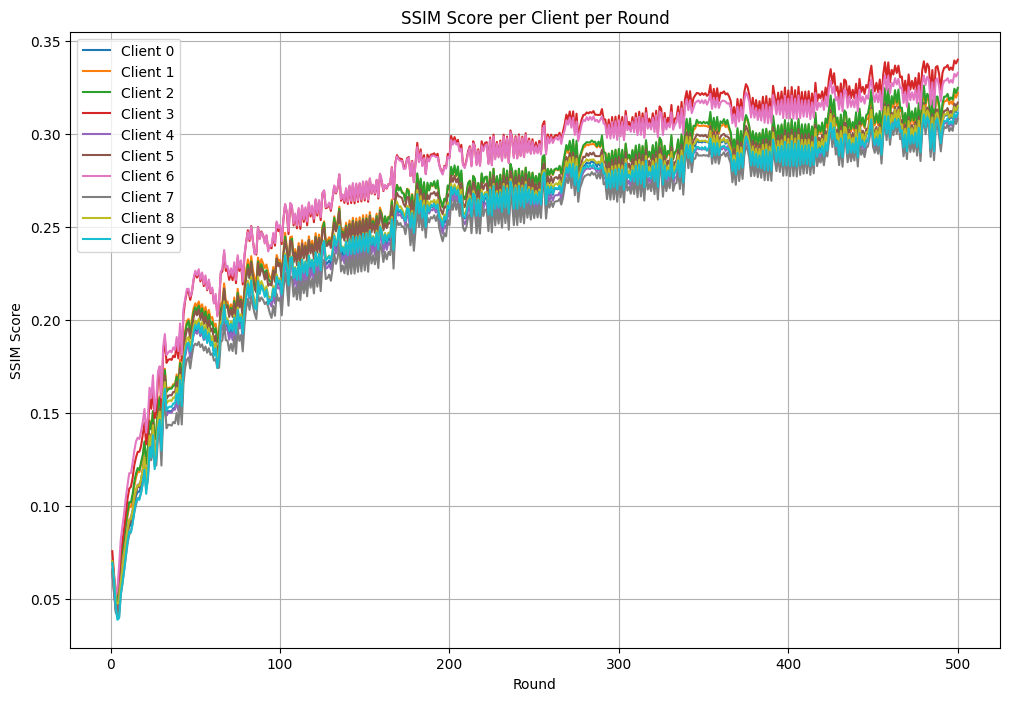

In [30]:
import matplotlib.pyplot as plt

def plot_ssim_scores(file_path: str):
    """Plot the SSIM scores of each client per round using the saved values."""
    round_times = []
    round_numbers = []
    client_ssim = {}

    with open(file_path, 'r') as file:
        for line in file:
            if line.startswith('Time'):
                parts = line.split(' - ')
                round_times.append(parts[1])
                round_numbers.append(int(parts[1].split()[1]))
            else:
                client_id, ssim_score = line.split()
                if client_id not in client_ssim:
                    client_ssim[client_id] = []
                client_ssim[client_id].append(float(ssim_score))

    # Plotting
    plt.figure(figsize=(12, 8))
    for client_id, ssim_scores in client_ssim.items():
        plt.plot(round_numbers, ssim_scores, label=f'Client {client_id}')

    plt.xlabel('Round')
    plt.ylabel('SSIM Score')
    plt.title('SSIM Score per Client per Round')
    plt.legend()
    plt.grid(True)
    plt.show()

# Example usage
plot_ssim_scores('ssim_scores.ncol')

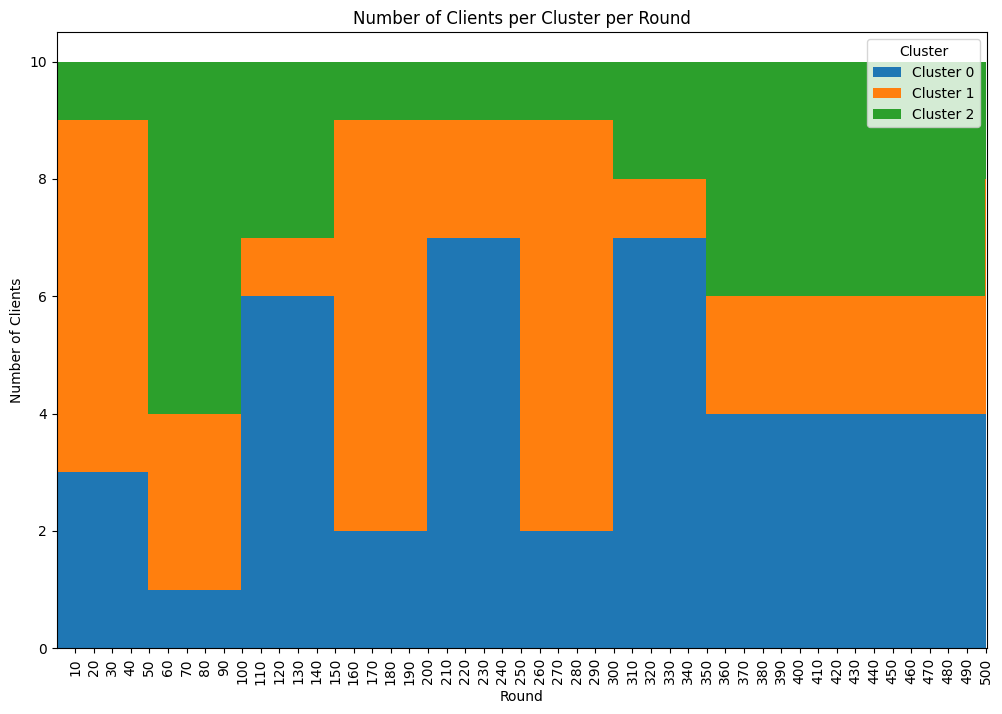

In [31]:
import h5py
import pandas as pd
import matplotlib.pyplot as plt

def plot_clients_per_cluster(file_path='cluster_assignments.h5'):
    rounds = []
    client_clusters = {}

    with h5py.File(file_path, 'r') as f:
        for round_num in f.keys():
            rounds.append(int(round_num))
            client_ids = f[round_num]['client_ids'][:]
            cluster_labels = f[round_num]['cluster_labels'][:]
            for client_id, cluster_label in zip(client_ids, cluster_labels):
                if int(round_num) not in client_clusters:
                    client_clusters[int(round_num)] = []
                client_clusters[int(round_num)].append(cluster_label)
    
    rounds = sorted(rounds)
    cluster_counts = {round_num: [0] * 3 for round_num in rounds}  # Assuming 3 clusters

    for round_num in rounds:
        clusters = client_clusters[round_num]
        for cluster in clusters:
            cluster_counts[round_num][cluster] += 1

    # Prepare data for plotting
    data = pd.DataFrame(cluster_counts).T
    data.columns = [f'Cluster {i}' for i in range(3)]
    
    # Plotting the data
    ax = data.plot(kind='bar', stacked=True, figsize=(12, 8), width=1.0)  # Adjust width to remove spacing between columns
    plt.xlabel('Round')
    plt.ylabel('Number of Clients')
    plt.title('Number of Clients per Cluster per Round')

    # Set the x-axis ticks to show the round value only every 10 rounds
    tick_positions = [i for i in range(len(rounds)) if rounds[i] % 10 == 0]
    tick_labels = [str(rounds[i]) for i in tick_positions]
    ax.set_xticks(tick_positions)
    ax.set_xticklabels(tick_labels)

    plt.legend(title='Cluster')
    plt.show()

# Call the function to plot the graph
plot_clients_per_cluster()

Image: 02.jpeg
Anomaly: True, Loss: 2654.3408, Threshold: 1100.0000


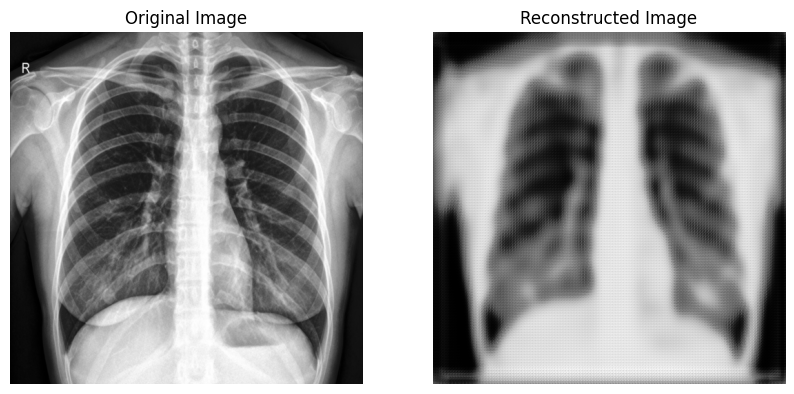

In [34]:
import os
import random
import torch
from PIL import Image
import torchvision.transforms as transforms
import torch.nn.functional as F
import matplotlib.pyplot as plt

# Define the model and anomaly detection functions
def load_model(model_path):
    net = SparseAutoencoder()
    state_dict = torch.load(model_path, map_location=torch.device('cpu'))  # Load the state dictionary
    net.load_state_dict(state_dict)  # Load the state dictionary into the model
    net.eval()
    return net

def check_anomaly(image_path, model, threshold):
    transform = transforms.Compose([
        transforms.Resize((512, 512)),
        transforms.ToTensor()
    ])

    image = Image.open(image_path).convert('L')
    image = transform(image).unsqueeze(0)

    with torch.no_grad():
        reconstructed = model(image)

    loss = F.mse_loss(reconstructed, image, reduction='sum').item()

    is_anomaly = loss > threshold
    return is_anomaly, loss, image, reconstructed

# Function to pick a random image from the directory and check for anomaly
def check_random_image(directory, model, threshold=0.01):
    image_files = [f for f in os.listdir(directory) if os.path.isfile(os.path.join(directory, f))]
    random_image_file = random.choice(image_files)
    random_image_path = os.path.join(directory, random_image_file)

    is_anomaly, loss, original_image, reconstructed_image = check_anomaly(random_image_path, model, threshold)

    print(f"Image: {random_image_file}")
    print(f"Anomaly: {is_anomaly}, Loss: {loss:.4f}, Threshold: {threshold:.4f}")

    # Display the original and reconstructed images
    original_image = original_image.squeeze().cpu().numpy()
    reconstructed_image = reconstructed_image.squeeze().cpu().numpy()

    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.title('Original Image')
    plt.imshow(original_image, cmap='gray')
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.title('Reconstructed Image')
    plt.imshow(reconstructed_image, cmap='gray')
    plt.axis('off')

    plt.show()

# Example usage:
model_path = 'latest_model_cluster_0.pth'
directory = 'NewNormal'
model = load_model(model_path)
check_random_image(directory, model, threshold=1100)